In [1]:
import torch, torchvision
from torchvision import models,datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torchvision.models import resnet50,ResNet50_Weights,Inception_V3_Weights
import numpy as np
import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
class CNN(nn.Module):
    def __init__(self, train_CNN=False, num_classes=10):
        super(CNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.inception(images)
        return self.sigmoid(self.dropout(self.relu(features))).squeeze(1)

In [3]:
model = CNN()
model.eval();

In [4]:
import json
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

X,y = shap.datasets.imagenet50()
X /= 255

In [5]:
import cv2 as cv
def read_img(path_to_img):
    img = cv.imread(path_to_img) # Insert the path to image.
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# define the transformations (here we are using the ImageNet transformations)

def transform_img(img,transform_flag = 'Y'):
    transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
    arr_img = np.array(img)
    # apply the transforms
    trans_img = transform(arr_img)
    # unsqueeze to add a batch dimension
    trans_img = trans_img.unsqueeze(0)
    if transform_flag == 'N':
        trans_img = np.array(trans_img)
        trans_img = trans_img.swapaxes(-1,1)
        return trans_img
    else:
        return trans_img


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()


In [6]:
# read and visualize the image
path_to_img = 'images/Iguana.jpeg'
img = read_img(path_to_img)

background = normalize(X)
test_image = transform_img(img)
background.shape, test_image.shape

(torch.Size([50, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [7]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_image)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [8]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_image.numpy(), 1, -1), 1, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


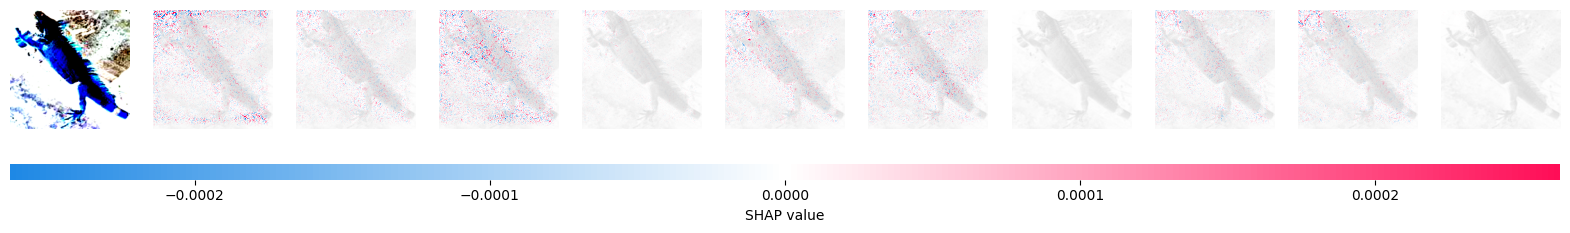

In [9]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)